Importing Libraries

In [19]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Load the dataset and dispalay some other informations about the csv

In [2]:
# Load the dataset
file_path = 'datasets/mobile_price.csv'
df = pd.read_csv(file_path)

# Display initial dataset information
print("First few rows of the dataset:")
print(df.head())
print("\nDataset Columns:", df.columns)
print("\nDataset Shape:", df.shape)
print("\nDataset Info (Data Types & Missing Values):")
print(df.info())
print("\nDataset Values (First Few):")
print(df.values)

First few rows of the dataset:
   battery_power    ram  int_memory  mobile_wt  processor_speed  fc  pc  \
0           3249   7241      206600     223.02             2.07  15  24   
1           3330  10869      206113     115.85             1.88  10  36   
2           3260   6630      270725     202.83             2.73   7  94   
3           3406   5399       77190     218.87             1.69  14  15   
4           4443   1604      238850     123.52             2.20  15  50   

   n_cores  talk_time     brand       os  touch_screen  wifi  three_g  four_g  \
0        5      13.32      Vivo      iOS             0     1        1       0   
1        6      34.20  Motorola  Android             0     1        0       0   
2        6      25.21    Xiaomi      iOS             1     1        0       1   
3        5      28.17    Xiaomi  Android             1     1        1       0   
4        6      36.15    Xiaomi      iOS             0     1        1       1   

   dual_sim  price  
0         

Explanatory Data Analysis

In [3]:
# Summary statistics of dataset
summary_stats = df.describe(include='all')
print("\nSummary Statistics:")
print(summary_stats)

# Check and handle missing values: Fill missing values with the mode (most frequent value)
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)
df.fillna(df.mode().iloc[0], inplace=True)

# Check for duplicate rows
duplicates = df[df.duplicated(keep=False)]
if not duplicates.empty:
    print("\nDuplicate rows found:")
    print(duplicates)
else:
    print("\nNo duplicates found.")

# Remove duplicate rows if any
df.drop_duplicates(inplace=True)

# Check for missing values after filling
missing_values = df.isnull().sum()
print("\nMissing Values After Imputation:")
print(missing_values)


Summary Statistics:
        battery_power           ram     int_memory   mobile_wt  \
count      800.000000    800.000000     800.000000  800.000000   
unique            NaN           NaN            NaN         NaN   
top               NaN           NaN            NaN         NaN   
freq              NaN           NaN            NaN         NaN   
mean      3498.106250   8464.953750  255886.053750  177.137800   
std       1452.802176   4182.123143  146135.810162   43.162923   
min       1006.000000   1000.000000    8253.000000  100.010000   
25%       2240.000000   5047.000000  130995.750000  140.127500   
50%       3508.000000   8262.500000  253484.000000  178.515000   
75%       4757.250000  12115.250000  378029.000000  215.182500   
max       5999.000000  15977.000000  511949.000000  249.560000   

        processor_speed          fc          pc     n_cores   talk_time  \
count        800.000000  800.000000  800.000000  800.000000  800.000000   
unique              NaN         NaN 

Classify categorical and numerical features and standardize categorical features

In [4]:
categorical_features = ['brand', 'os']
numerical_features = [col for col in df.columns if col not in categorical_features + ['price']]

# Standardize categorical values to lowercase for consistency
df[categorical_features] = df[categorical_features].apply(lambda x: x.str.lower())

Handle Inconsistencies and unexpected values

In [5]:
# check if 'price' or 'battery_power' has negative values
negative_price = df[df['price'] < 0]
negative_battery_power = df[df['battery_power'] < 0]
print("\nRows with Negative Price:\n", negative_price)
print("\nRows with Negative battery_power:\n", negative_battery_power)


Rows with Negative Price:
 Empty DataFrame
Columns: [battery_power, ram, int_memory, mobile_wt, processor_speed, fc, pc, n_cores, talk_time, brand, os, touch_screen, wifi, three_g, four_g, dual_sim, price]
Index: []

Rows with Negative battery_power:
 Empty DataFrame
Columns: [battery_power, ram, int_memory, mobile_wt, processor_speed, fc, pc, n_cores, talk_time, brand, os, touch_screen, wifi, three_g, four_g, dual_sim, price]
Index: []


Price Analysis Results and Outlier Detection

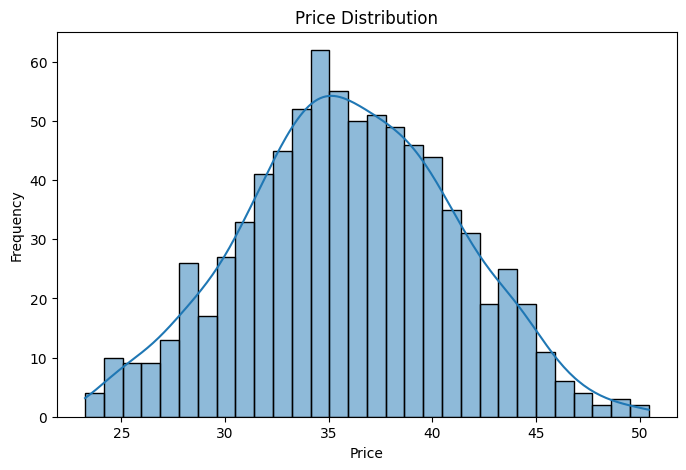

(count    800.000000
 mean      35.998250
 std        5.096324
 min       23.250000
 25%       32.615000
 50%       35.880000
 75%       39.580000
 max       50.440000
 Name: price, dtype: float64,
 1)

In [6]:
# Check basic statistics of the price column
price_column = "price"
if price_column in df.columns:
    price_stats = df[price_column].describe()
    
    # Identify potential outliers using IQR method
    Q1 = df[price_column].quantile(0.25)
    Q3 = df[price_column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[price_column] < lower_bound) | (df[price_column] > upper_bound)]
    outliers_count = outliers.shape[0]  # Correct variable name
    
    # Plot the price distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(df[price_column], bins=30, kde=True)
    plt.title("Price Distribution")
    plt.xlabel("Price")
    plt.ylabel("Frequency")
    plt.show()

    price_stats, outliers_count  # Return summary and number of outliers
else:
    price_stats = "Price column not found in dataset."
    outliers_count = 0

price_stats, outliers_count

Data Visualisation

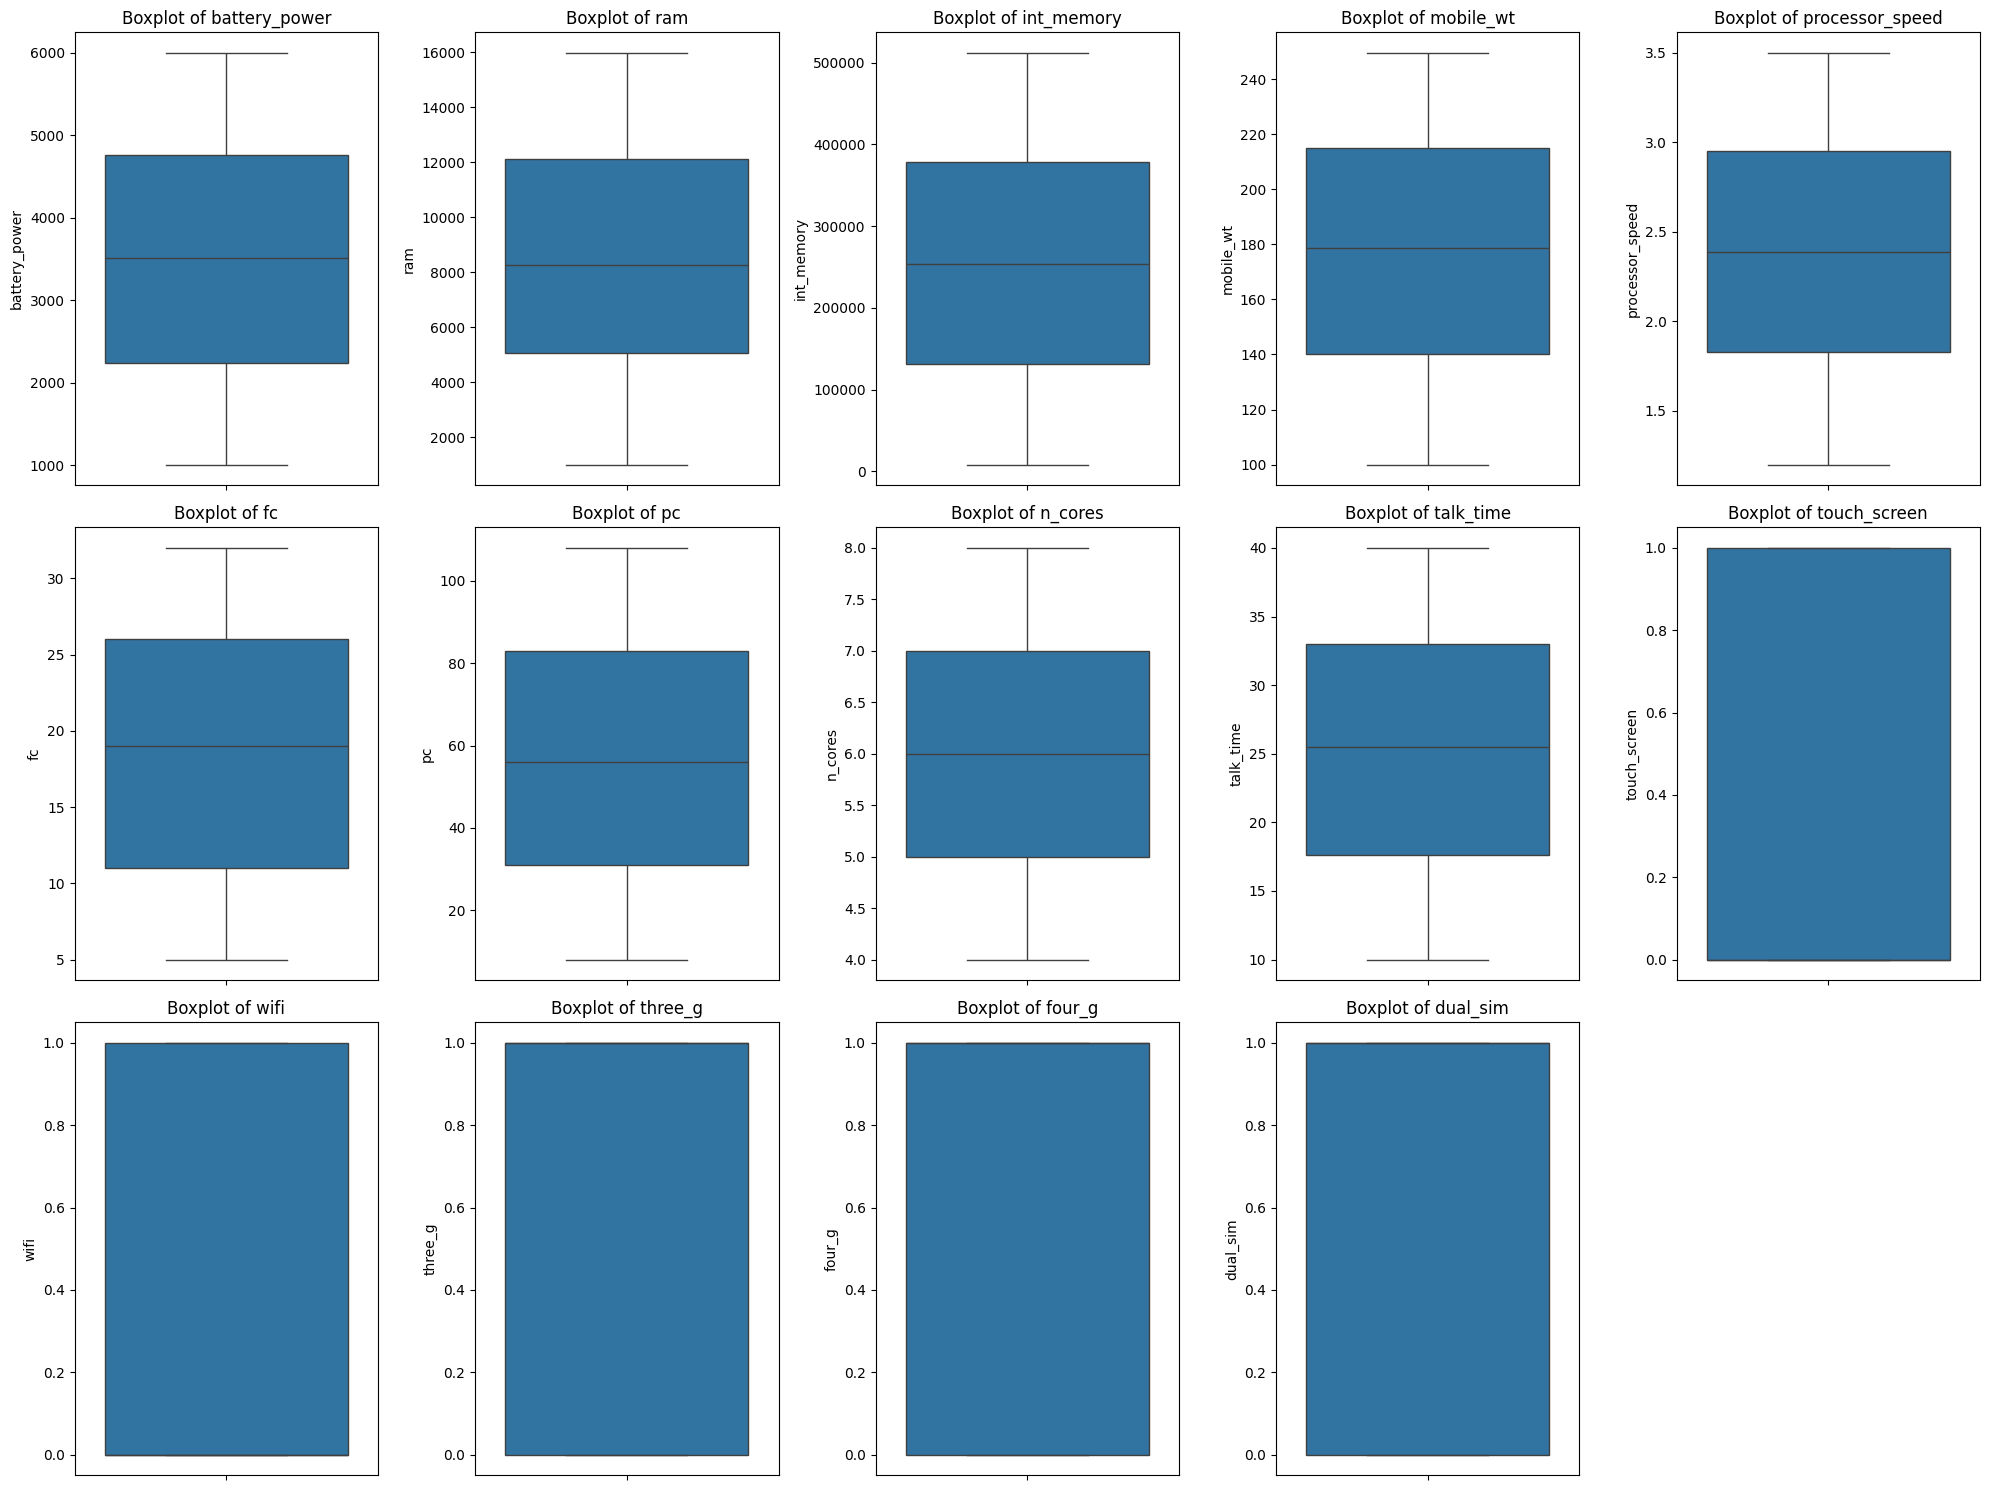


Value Counts for brand:
brand
huawei      98
samsung     90
xiaomi      82
realme      81
motorola    80
oneplus     79
vivo        78
apple       78
tecno       70
oppo        64
Name: count, dtype: int64

Value Counts for os:
os
android    405
ios        395
Name: count, dtype: int64


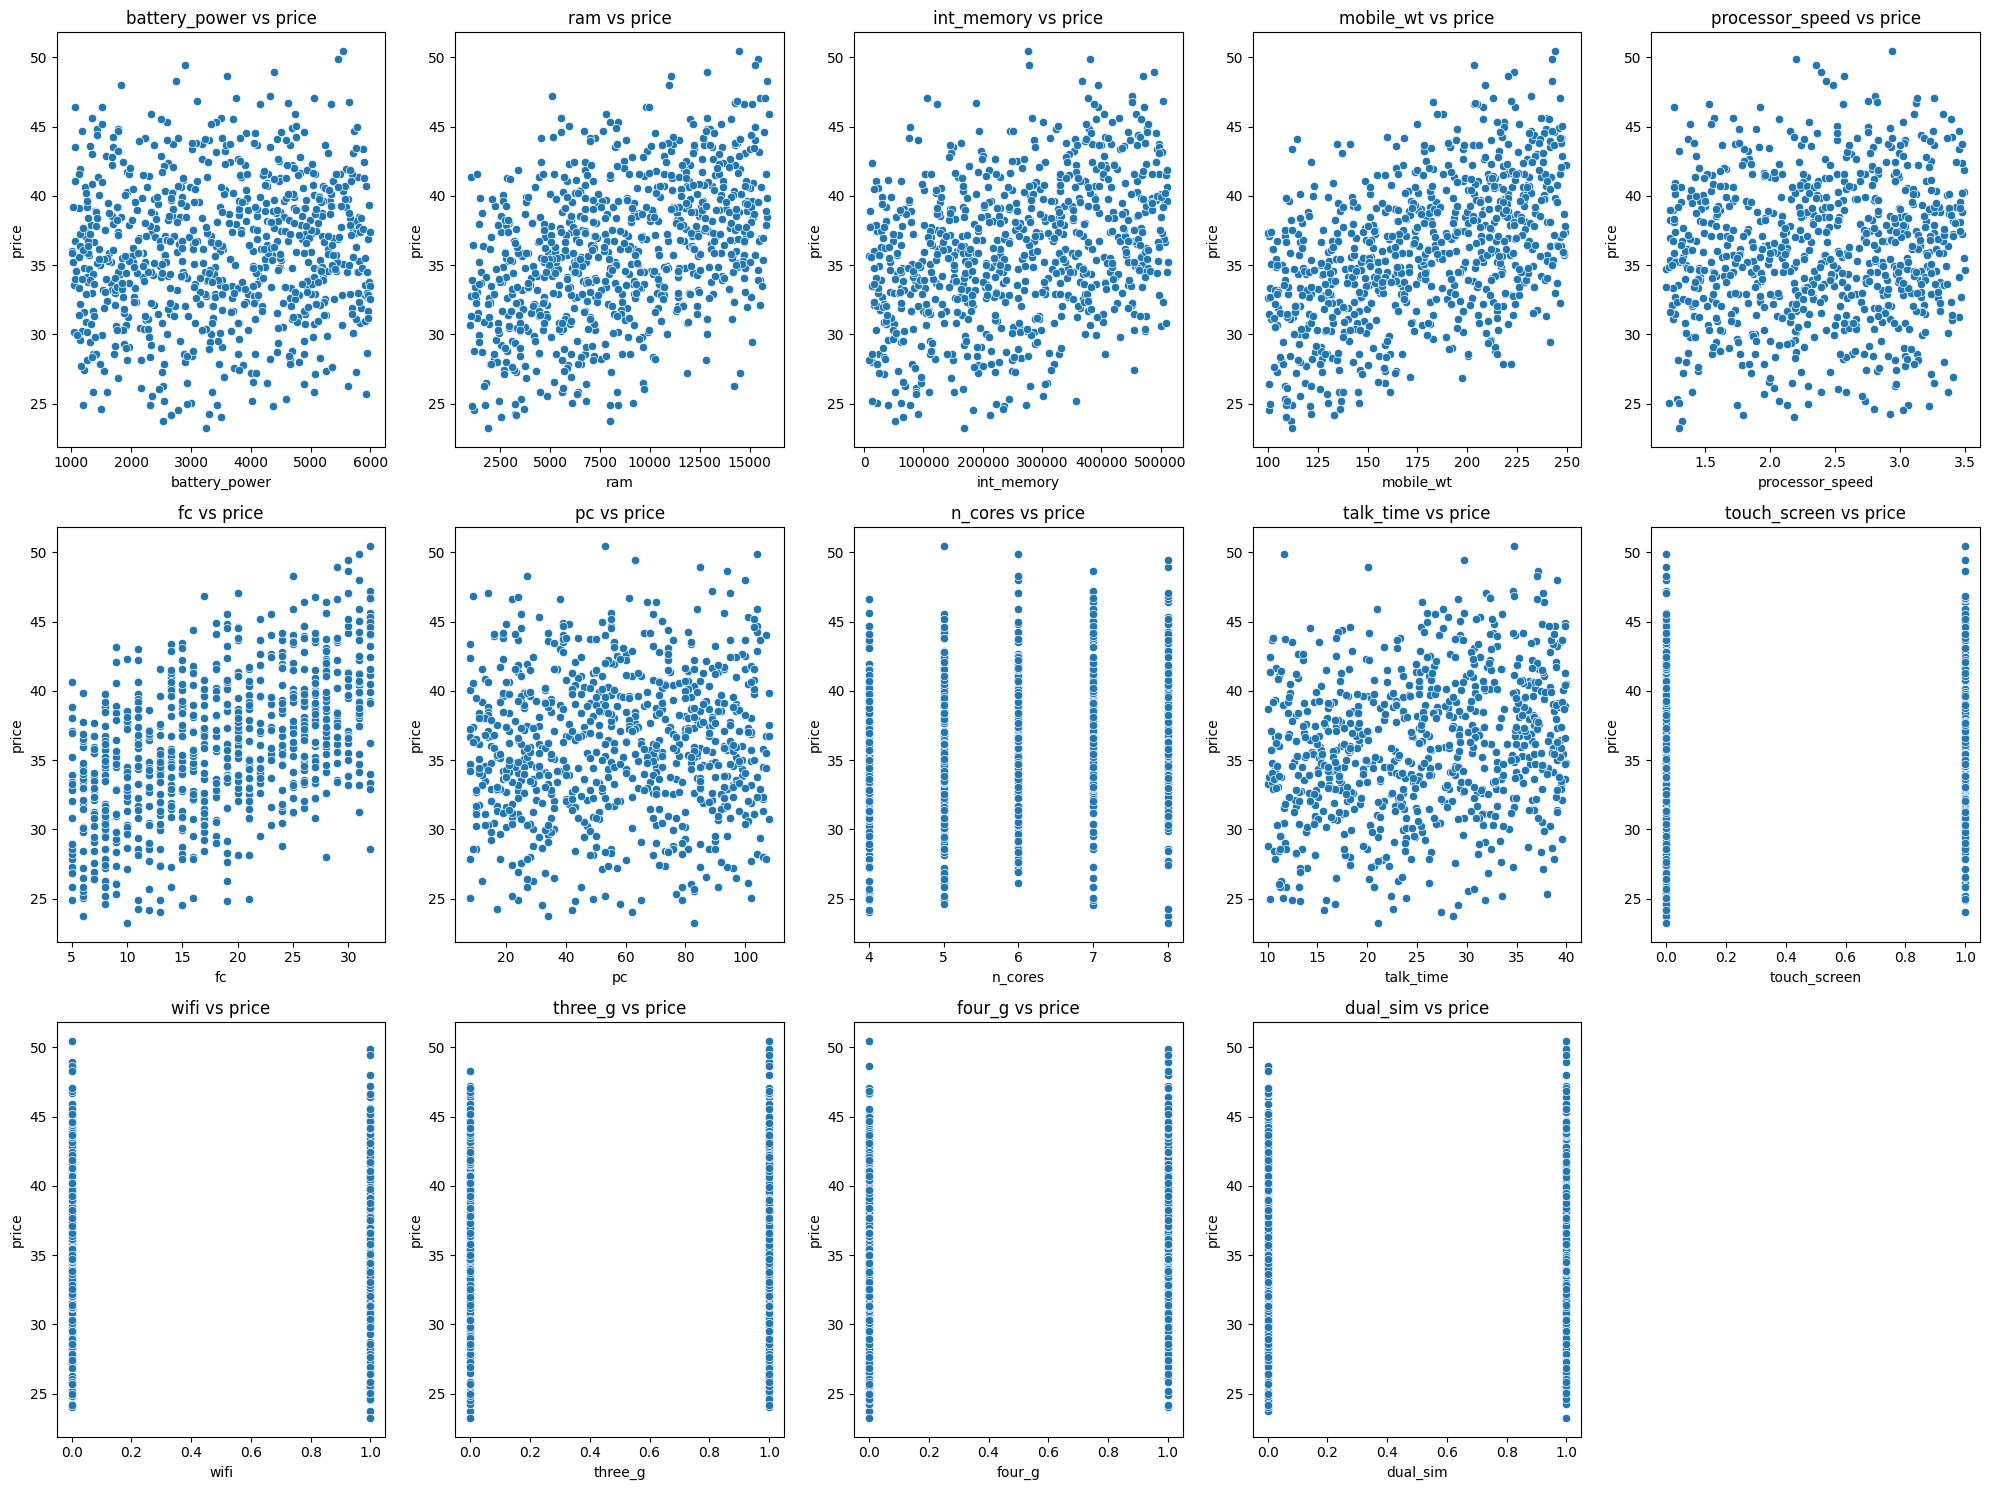

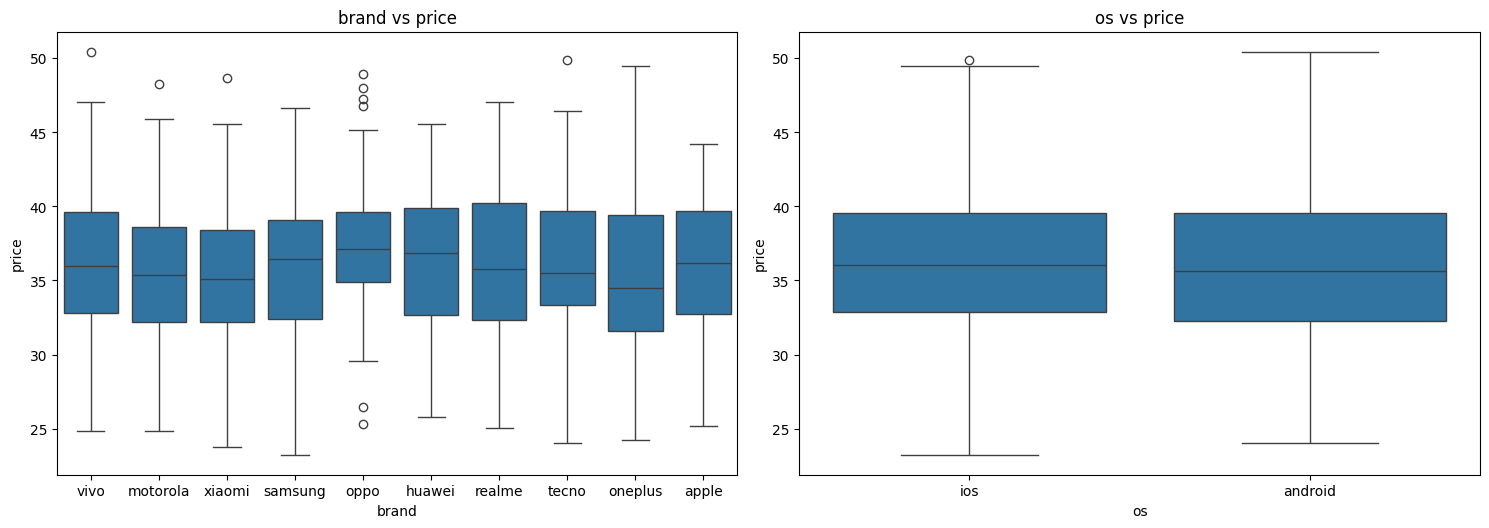

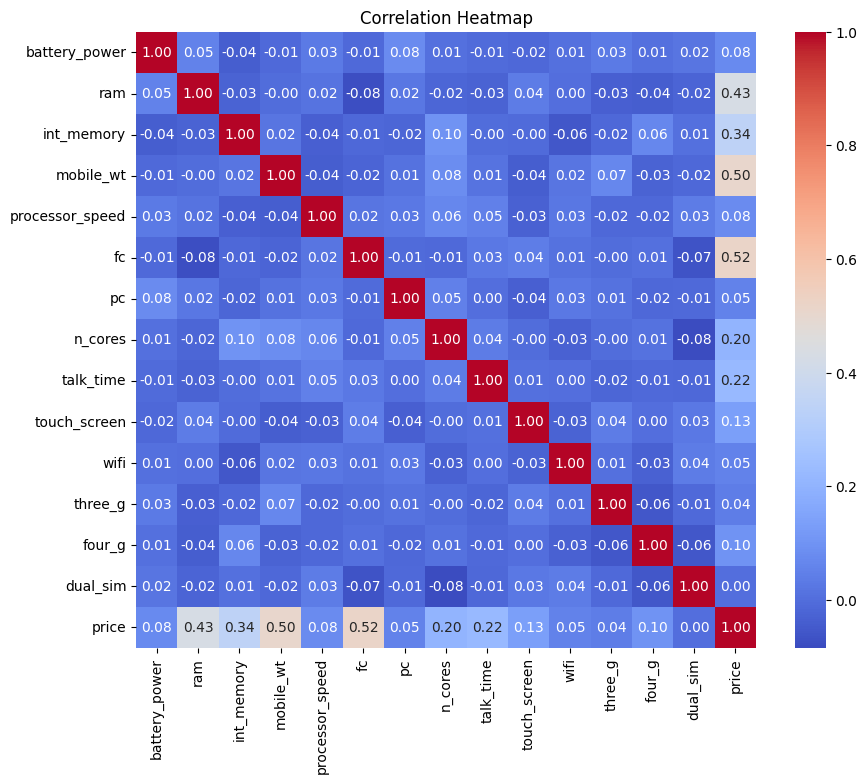

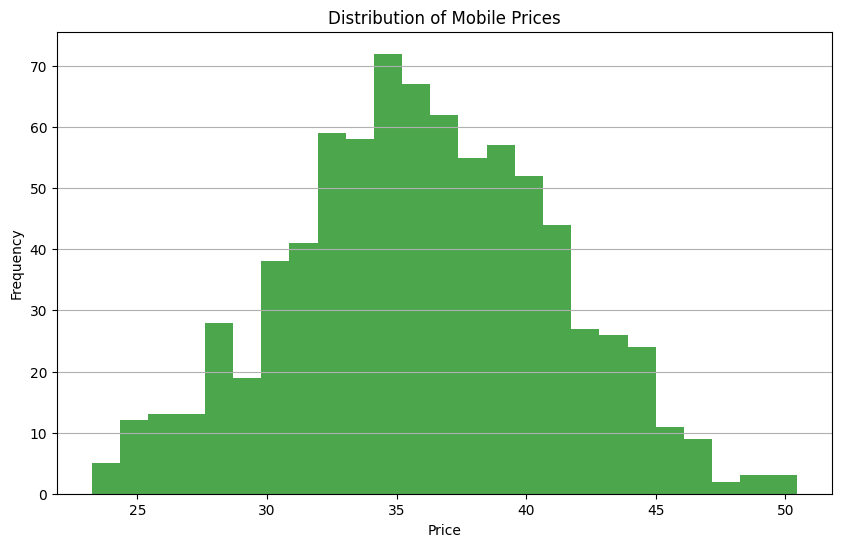

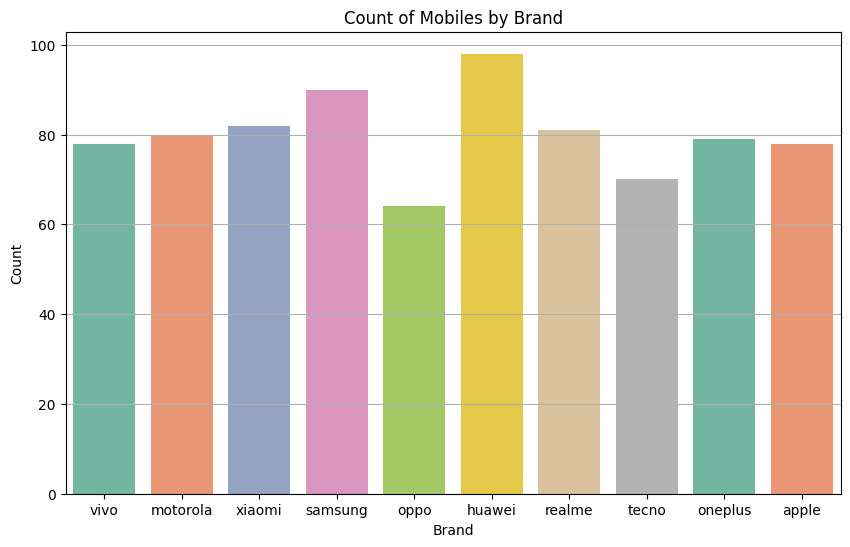

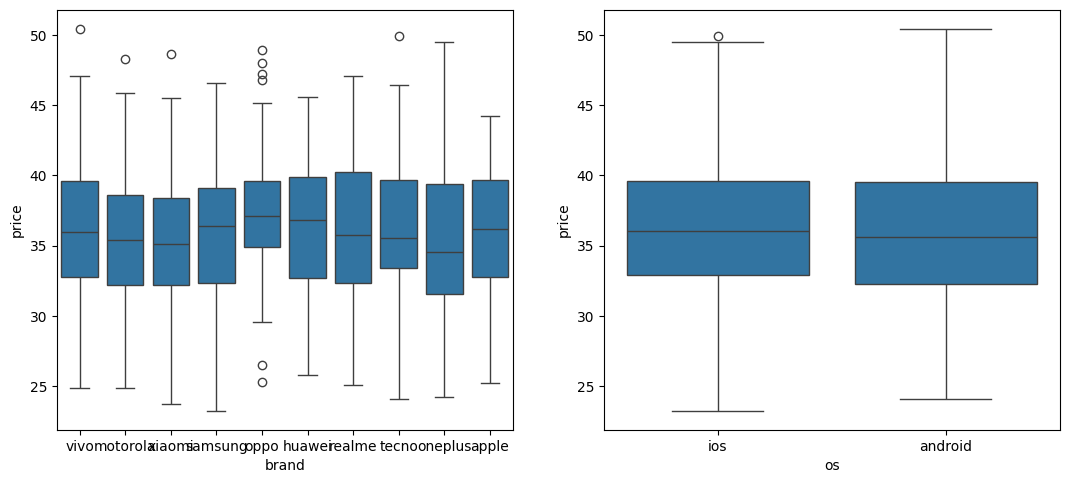

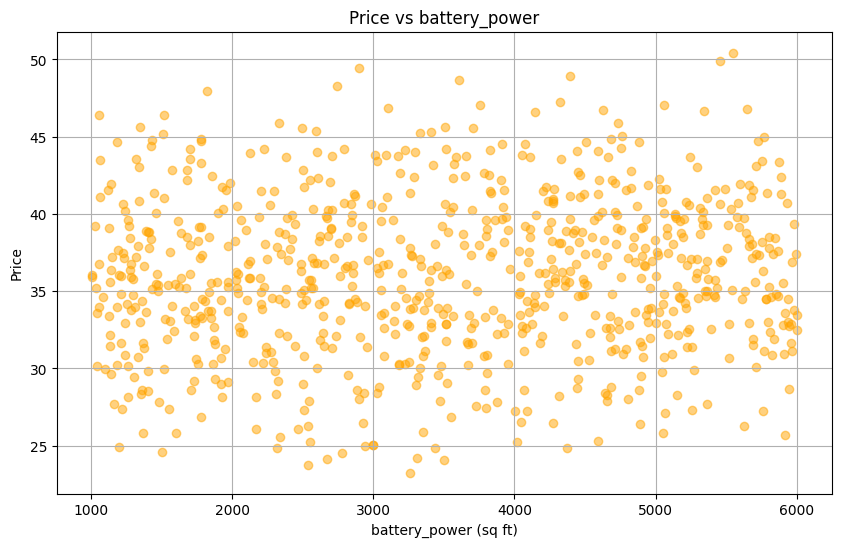

In [7]:

# Plot boxplots for numerical features to check for outliers
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 5, i)
    sns.boxplot(y=df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

# Check the distribution of categorical variables
for feature in categorical_features:
    print(f"\nValue Counts for {feature}:")
    print(df[feature].value_counts())

# Scatter plots for numerical features vs price to visualize relationships
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 5, i)
    sns.scatterplot(x=df[feature], y=df['price'])
    plt.title(f'{feature} vs price')
    plt.xlabel(feature)
    plt.ylabel('price')
plt.tight_layout()
plt.show()

# Box plots for categorical features vs price to visualize distribution
plt.figure(figsize=(15, 20))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x=df[feature], y=df['price'])
    plt.title(f'{feature} vs price')
    plt.xlabel(feature)
    plt.ylabel('price')
plt.tight_layout()
plt.show()

# Correlation heatmap for numerical features
correlation_matrix = df[numerical_features + ['price']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Distribution graph for the target variable (price)
plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=25, color='green', alpha=0.7)
plt.title('Distribution of Mobile Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

# Count plot for the 'brand' feature
plt.figure(figsize=(10, 6))
sns.countplot(x='brand', data=df, hue='brand', palette='Set2', legend=False)
plt.title('Count of Mobiles by Brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

# Box plots for brand and os vs price
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
sns.boxplot(x='brand', y='price', data=df)
plt.subplot(2, 3, 2)
sns.boxplot(x='os', y='price', data=df)
plt.show()

# Scatter graph for battery_power vs price
plt.figure(figsize=(10, 6))
plt.scatter(df['battery_power'], df['price'], alpha=0.5, color='orange')
plt.title('Price vs battery_power')
plt.xlabel('battery_power (sq ft)')
plt.ylabel('Price')
plt.grid()
plt.show()

Scale or normalize numerical features

In [8]:

# Scaling numerical features and target variable
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Apply separate scaling to 'price' and save the scaler
price_scaler = StandardScaler()
df[['price']] = price_scaler.fit_transform(df[['price']])
joblib.dump(price_scaler, "price_scaler.joblib")

['price_scaler.joblib']

Final data check

In [9]:
# Final dataset check
print("\nDataset Info after Preprocessing:")
print(df.info())
print("\nDataset Summary Statistics After Preprocessing:")
print(df.describe())


Dataset Info after Preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   battery_power    800 non-null    float64
 1   ram              800 non-null    float64
 2   int_memory       800 non-null    float64
 3   mobile_wt        800 non-null    float64
 4   processor_speed  800 non-null    float64
 5   fc               800 non-null    float64
 6   pc               800 non-null    float64
 7   n_cores          800 non-null    float64
 8   talk_time        800 non-null    float64
 9   brand            800 non-null    object 
 10  os               800 non-null    object 
 11  touch_screen     800 non-null    float64
 12  wifi             800 non-null    float64
 13  three_g          800 non-null    float64
 14  four_g           800 non-null    float64
 15  dual_sim         800 non-null    float64
 16  price            800 non-nu

Data Spliting to training and testing sets

In [10]:
# Split data into features (X) and target (y)
X = df.drop(columns=['price'])
y = df['price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale target variable
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

Data preprocessing

In [11]:
# Define preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(), [col for col in df.columns if col.startswith('brand_') or col.startswith('os_')])
])

# Define model pipeline with RandomForestRegressor
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

Hyperparameter tuning

In [12]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train_scaled)

# Print best hyperparameters
best_params = {key.replace('regressor__', ''): value for key, value in grid_search.best_params_.items()}
print("\nBest Hyperparameters from GridSearchCV:", best_params)


Best Hyperparameters from GridSearchCV: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


Model Training

In [13]:
# Train the model
model.fit(X_train, y_train_scaled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['battery_power', 'ram',
                                                   'int_memory', 'mobile_wt',
                                                   'processor_speed', 'fc',
                                                   'pc', 'n_cores', 'talk_time',
                                                   'touch_screen', 'wifi',
                                                   'three_g', 'four_g',
                                                   'dual_sim']),
                                                 ('cat', OneHotEncoder(),
                                                  [])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [14]:
# Train final model with best parameters
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(**best_params, random_state=42))
])
final_model.fit(X_train, y_train)


# Evaluate on the test set
y_pred_final = final_model.predict(X_test)
mae_final = mean_absolute_error(y_test, y_pred_final)
print(f"Final MAE: {mae_final}")

# Save the final model
joblib.dump(final_model, "model.joblib")

Final MAE: 0.3087268227894996


['model.joblib']

Make predictions on testing data

In [15]:
# Predict on the test set
y_pred_scaled = final_model.predict(X_test)

# Rescale predictions back to original price range
y_pred_final = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

Model Evaluation

In [16]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred_final)
mse = mean_squared_error(y_test, y_pred_final)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_final)

# Print evaluation results
print(f"\nModel Evaluation Results:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


Model Evaluation Results:
MAE: 0.31331238146249196
MSE: 0.14812553010513124
RMSE: 0.3848707966384709
R² Score: 0.8688283298826663


Visualization after evaluation

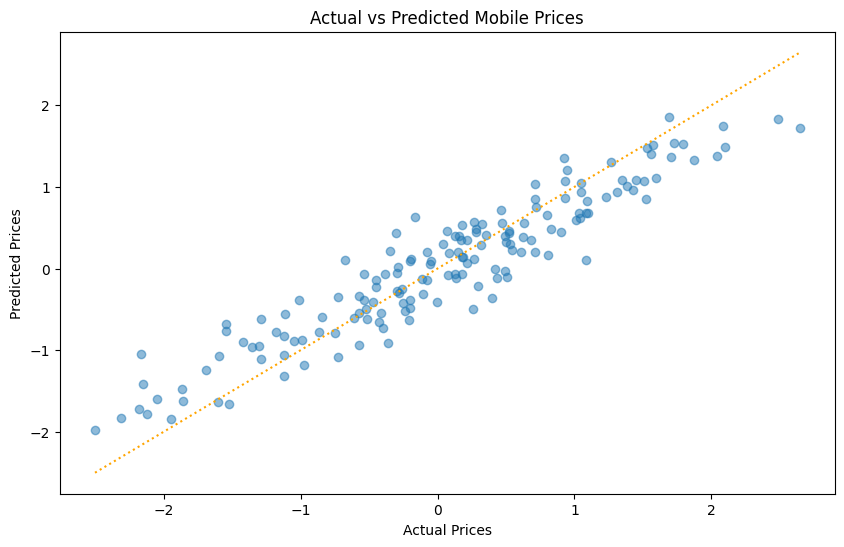

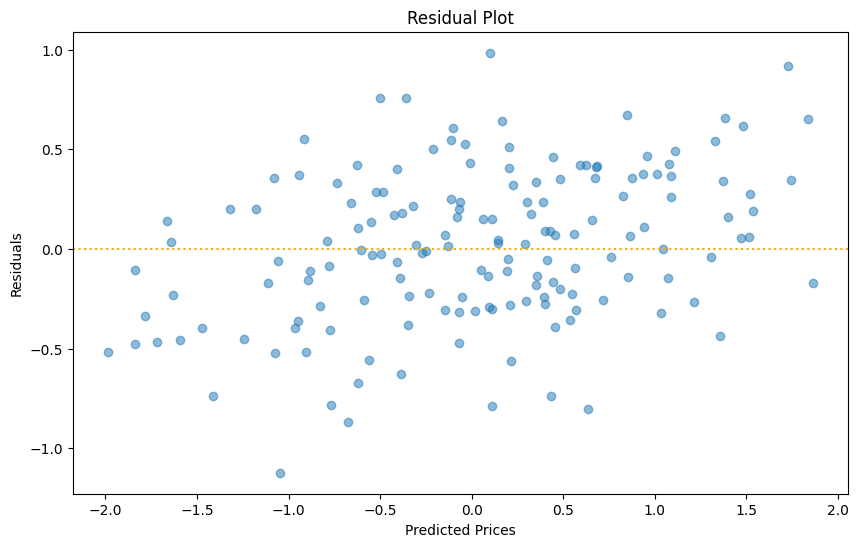

In [17]:
# Visualization: Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_final, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', linestyle='dotted')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Mobile Prices')
plt.show()

# Residual Plot
residuals = y_test - y_pred_final
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_final, residuals, alpha=0.5)
plt.axhline(y=0, color='orange', linestyle='dotted')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Model Performance Against Baseline

In [18]:
# Baseline Model for comparison
y_baseline = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_baseline)
mse_baseline = mean_squared_error(y_test, y_baseline)
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(y_test, y_baseline)

# Print baseline model evaluation
print(f"\nBaseline Model Evaluation:")
print(f"Baseline MAE: {mae_baseline}")
print(f"Baseline MSE: {mse_baseline}")
print(f"Baseline RMSE: {rmse_baseline}")
print(f"Baseline R²: {r2_baseline}")


Baseline Model Evaluation:
Baseline MAE: 0.8496200268714957
Baseline MSE: 1.1336182029026283
Baseline RMSE: 1.0647150806213972
Baseline R²: -0.0038687648551212206
